In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from motion_utils import *
from ot_utils import  *

In [59]:
df=pd.read_csv('simulated_runs.csv')

In [60]:
df=df.drop(df.columns[0],axis=1)

In [61]:
df

,run_num,t,x,y,intensity,id
0,0,0,7.660274,9.299760,8.013584,0
1,0,0,0.267214,7.266611,11.823975,1
2,0,0,8.209812,6.207118,7.959624,2
3,0,0,0.651430,0.305783,11.447588,3
4,0,0,6.104663,7.701214,6.717697,4
...,...,...,...,...,...,...
3015,19,19,2.500939,6.357124,27.046461,5
3016,19,19,8.754228,3.858660,4.922800,6
3017,19,19,1.324228,5.705852,9.712932,7
3018,19,19,1.819672,2.041279,11.288841,8


In [62]:
one_run=df.loc[df.run_num==0]

Before we decide how to get OT involved in this, let's first generate cost matrices according to some simple rule that is somewhat reasonable

In [158]:
normalize = lambda x : x/np.sum(np.abs(x))

In [159]:
frames=[one_run.loc[one_run.t==i].to_dict('records') for i in one_run.t.unique()]

In [160]:
def connection_likelihood(frame1,frame2):
    #Let's say we solve it first without disappearance
    '''for i,f1 in enumerate(frame1):
        for j,f2 in enumerate(frame2):
            print(i,j)
            print(1/((f2['x']-f1['x'])**2+(f2['y']-f1['y'])**2))
    '''
    C=np.array([normalize(np.log([1/((f2['x']-f1['x'])**2+(f2['y']-f1['y'])**2)  for f2 in frame2]))for f1 in frame1])
    return C

In [161]:
T=[connection_likelihood(frames[i],frames[i+1])for i in range(len(frames)-1)]#temporary costs of transport between consecutive images

In [162]:
T[0]

array([[ 0.0791107 , -0.2396852 , -0.12863488, -0.2799576 , -0.09344893,
        -0.17916269],
       [-0.18516598,  0.16798051, -0.19569968, -0.18188983, -0.16365859,
        -0.10560542],
       [-0.11027008, -0.23129824,  0.11729241, -0.24366298, -0.1047369 ,
        -0.1927394 ],
       [-0.21097169, -0.17019359, -0.2026206 ,  0.02927309, -0.19574642,
        -0.19119461],
       [-0.04391518, -0.13646215, -0.07629155, -0.16624292,  0.48805458,
        -0.08903362],
       [-0.15786335, -0.12175835, -0.1875027 , -0.22509124, -0.12642672,
         0.18135764]])

We come to the heart of the algorithm, or the depths of my despair because I have no clue how it's going to work

In [163]:
used_points=[]#wll add tuples of (t,idx) of things that have already appeared in the higher scored paths
paths=[]
INF=1e7
def ml_path():
    tmp=[[{'value':0,'previous' : None} for j,target in enumerate(T[0][0])]]#highest price of reaching a given point at time t and idx of point we reach it from
    for j,target in enumerate(T[0][0]):
        tmp[0][j]={'value':0,'previous' : None}
    for time,M in enumerate(T):
        tmp.append([{'value':-INF,'previous' : None}for j,target in enumerate(M[0])])
        for i,row in enumerate(M):
            if((time,i) not in used_points):
                for j,target in enumerate(row):
                    if((time+1,j) not in used_points):
                        if(M[i][j]+tmp[time][i]['value']>tmp[time+1][j]['value']):
                            tmp[time+1][j]['value']=M[i][j]+tmp[time][i]['value']
                            tmp[time+1][j]['previous']=i#note index used
    #now that we did that it's time to recover a maximal path. It would be nice to make it recursive at some point but for now whatever.
    #print(tmp)
    t=len(tmp)-1#last index
    maxid=None
    maxval=-INF
    track=[]
    for j,target in enumerate(T[t-1]):
        if tmp[t][j]['value']>maxval:
            maxval=tmp[t][j]['value']
            maxid=j
    used_points.append((t,maxid))
    track.append((t,maxid))
    next_i=tmp[t][maxid]['previous']
    while(t>0):
        t-=1
        track.append((t,next_i))
        used_points.append((t,next_i))
        next_i=tmp[t][next_i]['previous']
    return track

Plot this and compare to ground truth. Ideally we would like a more methodical approach for measuring how good it is

In [164]:
tracks=[]
for i in range(T[0].shape[0]):
    tracks.append(ml_path())
for i,t in enumerate(tracks):
    t.reverse()

Visual comparison:

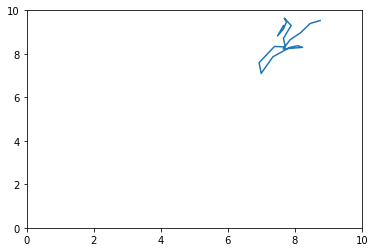

In [173]:
def track_id(idx):
    track=[(t,idx) for t in range(len(frames))]
    return track

fig,ax=plt.subplots()
ax.set_xlim([0,10])
ax.set_ylim([0,10])

track=tracks[1]
x_data=[frames[t[0]][t[1]]['x'] for t in track]
y_data=[frames[t[0]][t[1]]['y'] for t in track]
ax.plot(x_data,y_data)

In [134]:
frames[3]

[{'run_num': 0,
  't': 3,
  'x': 7.75009411462528,
  'y': 9.460844143803246,
  'intensity': 7.151063145843136,
  'id': 0},
 {'run_num': 0,
  't': 3,
  'x': 0.1095014565747062,
  'y': 7.657316884413103,
  'intensity': 10.94625134140929,
  'id': 1},
 {'run_num': 0,
  't': 3,
  'x': 8.540687415480479,
  'y': 5.740417151691509,
  'intensity': -4.973045373765293,
  'id': 2},
 {'run_num': 0,
  't': 3,
  'x': 1.5515923744839335,
  'y': 0.1668497358244725,
  'intensity': 16.047622973875477,
  'id': 3},
 {'run_num': 0,
  't': 3,
  'x': 6.842885901512641,
  'y': 6.920600917007161,
  'intensity': 9.262693953307362,
  'id': 4},
 {'run_num': 0,
  't': 3,
  'x': 2.5641222385618905,
  'y': 9.756271745965991,
  'intensity': 6.973918920431308,
  'id': 5}]